## Core

In [ ]:
#| default_exp magic_cell

In [ ]:
#| hide
# %load_ext autoreload
# %autoreload 2

In [ ]:
#| hide
from dotenv import load_dotenv
import os

In [ ]:
#| hide
load_dotenv();

## Friend**LL**y

In [ ]:
#| exporti

system_prompt="""
You are Claude, a very knowledgeable and intelligent research assistant.
Fulfill simple requests right away.
For more complicated tasks, use <thought> to plan your actions.

When appropriate, use Jupyter notebook. It has python 3.10+ and many packages installed.
Use <code> to add a new code cell at the end of your message. You will receive all its output on the next turn.

Prefer short cells that can be tested quickly.

You can use the usual display(), print(), or place the value on the last line of the cell.
Make sure to not add anything after that value, as it won't be returned if it's not on the last line.
Only output a result once with one method.
Avid using .show() and close matplot figures before the end of the cell - use an explicit display().

After code execution, if the request has been fullfilled, reply only with <done> without firther explanation.
The user will ask follow-up questions if needed. Only do only what they asked for.
You should also end your text with <done> if there is no need to run code.

To show an example in python without running the code, use
```python
python code here
```

For example:
User: Calculate square root of pi
Assistant: <code>
import math
math.sqrt(math.pi)
</code>
User: <stdio>1.7724538509055159<stdio>
Assistant: <done>

User: Display cat.jpg and describe wat you see.
Assistant: <thought>I can use the PIL library for this.</thought><code>
from PIL import Image
Image.open("cat.jpg")
</code>
User: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=128x127>
User: <image message>
Assistant: *describes the cat in the image*

When writing code, use advanced python features. Assume all packages are installed.
Import modules before using them.
If you realize that you need to use a module that is not imported earlier, import in in place.
"""


In [ ]:
#| export

import sys
import base64
import json
from typing import List, Dict, Tuple
import textwrap
import warnings

from friendlly.notebook import (
    update_code_self,
    update_code_next,
    detect_environment,
    vscode_get_cells,
    nbclassic_patch_kernel,
    nbclassic_add_cell,
    nbclassic_update_cell,
    nbclassic_render_cell,
    nbclassic_execute_cell,
    nbclassic_delete_cell,
    nbclassic_get_cells,
    )


from friendlly.utils import nict, parse_cell_line, cell_to_blocks, make_cell_from_captured, merge_messages
from friendlly.config import handle_config
from friendlly.capture_trace import SaveTraceback
from friendlly.capture_display import PassthroughCapturer
from friendlly.capture_io import TeeIO
import claudette
from claudette import text_msg, img_msg, mk_msg


from IPython import get_ipython
from IPython.display import display, clear_output, Markdown, Javascript

In [ ]:
#| export

def cells_to_messages(cells):
    messages = []


    # We found the first %%fr message (request from user).
    # This means that we treat further cells (markdown and code without %%fr) as assistant-generated.
    user_message_found = False
    for cell in cells:
        cell_friendlly, cell_reply, code_text, output_blks = cell_to_blocks(cell)

        if code_text:
            # If the cell is marked with %%fr reply, or we found the user request above.
            if cell_reply:       role="assistant"  # Messages has '%%fr reply'
            elif cell_friendlly: role="user" # Message has %%fr without 'reply'
            else:                role="assistant" if user_message_found else "user" # It's not an %%fr cell.

            # We found an %%fr cell that is not a reply - means it's a user message!
            if cell_friendlly and not cell_reply: user_message_found=True

            # Assistant code gets wrapped into tags, user code gets wrapped into ```
            # Markdown is passed as is.
            if role == "assistant" and cell.cell_type == "code":
                code_text = f"<code>{code_text}</code>"
            elif role == "user":
                code_text = f"```\n{code_text}\n```"

            messages.append(mk_msg([code_text], role=role))

        # Outputs for both user and assistant code cells are always user messages.
        if output_blks:
            messages.append(mk_msg(output_blks, role="user"))

    return [nict(m) for m in messages]

In [ ]:
#| export

class CellChat():
    def __init__(self, config):
        self.config = config
        # self.display_handle = None # Used when config.md_cell=False
        self.history = []
        self.client = claudette.Client(model=self.config.model)

    def update_markdown(self, text):
        raise NotImplementedError

    def delete_markdown(self):
        raise NotImplementedError

    def update_code(self, code):
        raise NotImplementedError

    def update_code_final(self, code):
        raise NotImplementedError

    def go(self, idx,  num_above, messages):
        self.idx = idx
        self.added_md_cell = self.added_code_cell = False
        self.thought_display_id = None
        self.history.append(messages)

        tokens = []
        try:
            md_reply = ""
            md_updated = False
            code_reply = ""
            code_updated = False
            thought = ""

            state = "md"

            r = self.client(messages,
                            sp=self.config.system_prompt,
                            stream=True,
                            stop=["</code>", "<done>"])
            for token in r:
                tokens.append(token)
#                 print(state, f"'{token}'", f"'{code_reply}'", f"'{md_reply}'")

                if state == "md":
                    md_reply += token
                    md_updated = True

                    if "<code>" in md_reply:
                        md_reply, code_reply = md_reply.split("<code>")
                        code_updated = True
                        state = "code"

                    if "<thought>" in md_reply:
                        md_reply_body, thought = md_reply.split("<thought>")
                        state = "thought"

                elif state == "thought":
                    thought += token
                    md_tail = ""
                    md_updated = True

                    def combine_md_reply(body, thought, tail=""):
                        return f'{body}<details><summary style="display: list-item">🧠</summary>{thought}</details>{tail}'

                    if "</thought>" in thought:
                        thought, md_tail = thought.split("</thought>")
                        state = "md"
                    md_reply = combine_md_reply(md_reply_body, thought, md_tail)

                else: #code
                    code_reply += token
                    code_updated = True

                if md_updated:
                    md_updated = False
                    if md_reply.strip():
                        self.update_markdown(md_reply.strip())
                    else:
                        self.delete_markdown()

                if code_updated:
                    code_updated = False

                    self.update_code(code_reply.strip())

            if code_reply.strip():
                prefix = f"%%fr +{num_above + 2 if self.added_md_cell else 1} reply\n"
                self.update_code_final(prefix + code_reply.strip())

            if self.client.stop_reason == "stop_sequence":
                tokens += self.client.stop_sequence
            self.history.append(claudette.mk_msg("".join(tokens), role="assistant"))

            code_cell_idx = None if self.idx is None else self.idx + int(self.added_code_cell) + int(self.added_md_cell)
            if md_reply and not self.added_md_cell: md_display = Markdown(md_reply)
            else: md_display = None
            # We return md_display to be re-displayed after cleanup if we did not use an extra cell for md.
            return code_cell_idx, md_display

        except BaseException as e:
            raise e
#             display(Markdown(f"🚫 {repr(e)}"))
#             get_ipython().showtraceback()

In [ ]:
#| export
class NBClassicChat(CellChat):
    def __init__(self, config):
        super().__init__(config)
        self.display_handle = None

    def update_markdown(self, text):
        # md_cells means we output the text as markdown cells.
        # Otherwise, we display them.
        if self.config.md_cells and self.idx is not None:
            if not self.added_md_cell:
                nbclassic_add_cell(self.idx+1, "markdown")
                self.added_md_cell = True
            nbclassic_update_cell(self.idx+1, text)
            nbclassic_render_cell(self.idx+1)
        else:
            if self.display_handle:
                self.display_handle.update(Markdown(text))
            else:
                self.display_handle = display(Markdown(text), display_id=True)

    def delete_markdown(self):
        if self.config.md_cells and self.added_md_cell:
            nbclassic_delete_cell(self.idx+1)
            self.added_md_cell = False
        elif self.display_handle:
            # Empty JS cells ge cleaned up after the cell is executed.
            self.display_handle.update(Javascript(""))

    def update_code(self, code):
        # Without idx, we will have to update the code in the final call using the payload method.
        if self.idx is not None:
            code_idx = self.idx+2 if self.added_md_cell else self.idx+1
            if not self.added_code_cell:
                nbclassic_add_cell(code_idx, "code")
                self.added_code_cell = True

            nbclassic_update_cell(code_idx, code)

    def update_code_final(self, code):
        if self.idx is not None:
            code_idx = self.idx+2 if self.added_md_cell else self.idx+1
            if not self.added_code_cell:
                nbclassic_add_cell(code_idx, "code")
                self.added_code_cell = True

            nbclassic_update_cell(code_idx, code)
        else:
            # We got no index will have to resort to the native ipython method.
            update_code_self(code)

In [ ]:
#| export
class NoJSChat(CellChat):
    """
    This chat variant does not use JS inhection that is only available in Jupyter nbclassic.
    """

    def __init__(self, config):
        super().__init__(config)
        self.md_handle = None
        self.code_handle = None

    def update_markdown(self, text):
        if self.md_handle:
            self.md_handle.update(Markdown(text))
        else:
            self.md_handle = display(Markdown(text), display_id=True)

    def delete_markdown(self):
        if self.md_handle:
            self.md_handle.update(Javascript(""))

    def update_code(self, code):
        code = Markdown(f"```\n{code}\n```")
        if not self.code_handle:
            self.code_handle = display(Markdown("⌛"), display_id=True)
            self.num_code_updates = 1
        else:
            self.code_handle.update(Markdown(f"{'⏳' if self.num_code_updates % 2 else '⌛'}"))
            self.num_code_updates += 1

    def update_code_final(self, code):
        if self.code_handle:
            self.code_handle.update(Javascript("")) # Will be cleaned up shortly.
        update_code_next(code)

In [ ]:
#| export

env = detect_environment()

config = nict(
    environment=env,
    autorun=(env == "nbclassic"),
    md_cells=(env == "nbclassic"),
    comment_after_run=True,
    api_key=None,
    model="claude-3-5-sonnet-20240620",
    system_prompt=system_prompt
)

chat = None
def fr_cell(line=None, cell=None):
    global chat
    global config

    if config.environment == "nbclassic":
        chat = NBClassicChat(config=config)
    else:
        chat = NoJSChat(config=config)

    num_cells, is_friendlly, is_reply, is_config = 0, False, False, False
    idx = None
    ip = get_ipython()
    prev_messages = []
    if line:
        # line comes with magic already stripped.
        num_cells, is_friendlly, is_reply, is_config = parse_cell_line("%%fr " + line)
        if num_cells and not is_config:
            assert is_friendlly, "Called on a cell without %%fr?"

            if config.environment == "nbclassic":
                idx, cells_above = nbclassic_get_cells(num_cells)
            elif config.environment == "vscode":
                idx, cells_above = vscode_get_cells(num_cells)
            else:
                warnings.warn("Only nbclassic and vscode environments can access previous cells")
            prev_messages = cells_to_messages(cells_above)

    if is_config:
        handle_config(cell)
        return

    if idx is None:
        if config.environment == "nbclassic":
            idx, _ = nbclassic_get_cells(0)
        elif config.environment == "vscode":
            idx, _ = vscode_get_cells(0)

    # If it's a folllow-up message, we should first run the current cell and collect its outputs,
    # then pass the outputs to the chat as user messages for further generation.

    disp_capturer = PassthroughCapturer()
    if is_reply:
        disp_capturer.start()

        sys.stdout = stdout = TeeIO(sys.stdout)
        sys.stderr = stderr = TeeIO(sys.stderr)

        traceback = SaveTraceback(ip._showtraceback)
        traceback.register()

        # This runs the current cell, and we should capture all its outputs.
        res = ip.run_cell(cell)

        traceback.unregister()
        disp_capturer.stop()
        sys.stdout = stdout._stream
        sys.stderr = stderr._stream

        new_cell = make_cell_from_captured(source="%%fr " + line + "\n" + cell,
                                           res=res,
                                           stdout=stdout.getvalue(),
                                           stderr=stderr.getvalue(),
                                           displays=disp_capturer.get_outputs(),
                                           tracebacks=traceback.tracebacks)
        prev_messages += cells_to_messages([new_cell])

    else:
        prev_messages.append(nict(mk_msg(cell, role="user")))

    prev_messages = merge_messages(prev_messages)
    # Assistant message can't be the first in the conversation, nor can it be the last.
    if prev_messages:
        if prev_messages[0].role == "assistant":
            prev_messages.insert(0, nict(mk_msg("(Beginning of the conversation truncated)", role="user")))
        if prev_messages[-1].role == "assistant":
            prev_messages.append(nict(mk_msg("Continue", role="user")))

    # md_reply
    code_idx, md_display = chat.go(idx, num_cells, prev_messages)

    # If it's a reply cell, comment out the magic. Otherwise, comment out the
    # whole cell, as it's likely plain text, and not valid Python.
    # This makes it easy to re-run the ai-generated notebook manually without triggering the ai.
    cell_text = f"%%fr {line}\n{cell.strip()}".splitlines()
    if is_reply:
        cell_text[0] = "# " + cell_text[0]
    elif config.comment_after_run:
        cell_text = ["# " + l for l in cell_text]

    update_code_self("\n".join(cell_text))

    # This schedules the execution of the next cell.
    if (config.autorun
        and idx is not None
        and code_idx is not None
        and code_idx != idx):
        nbclassic_execute_cell(code_idx)

    # We might have created some invisible JS display outputs. Unfortunaely I don't think there is a way
    # to clear them without removing everying.
    clear_output()

    if is_reply:
        # Re-display the outputs.
        if stdout.getvalue(): print(stdout.getvalue())
        if stderr.getvalue(): print(stderr.getvalue(), file=sys.stderr)

        for d in disp_capturer.raw_outputs:
            ip.display_pub.publish(**d)
        for tb in traceback.tracebacks:
            ip._showtraceback(tb.ename, tb.evalue, tb.traceback)

    if md_display: display(md_display)
    if is_reply: return res.result

In [ ]:
#| eval: false
get_ipython().register_magic_function(fr_cell, 'cell', magic_name='fr')
if detect_environment() == "nbclassic":
    nbclassic_patch_kernel()

In [ ]:
# %%fr
# Download an image of a cat, resize it to 200 on the long side and show it.
# Then describe it briefly in the style of Jeremy Howard.

Certainly! Let's download an image of a cat, resize it, display it, and then I'll describe it in Jeremy Howard's style.



Alright, let's describe this adorable feline in Jeremy Howard's enthusiastic and engaging style:

Wow, would you look at that! We've got ourselves a proper cat here, and it's absolutely fantastic. This little ginger beauty is just sitting there, cool as a cucumber, giving us the most delightful squinty-eyed smile. It's like it's saying, "Yeah, I know I'm adorable, what are you going to do about it?"

The cat's got this gorgeous creamy orange fur that's practically glowing in the light. And those ears! They're perked up like little radar dishes, probably picking up on all sorts of interesting sounds we can't even hear.

But the real star of the show here is that face. That expression is priceless! It's got its eyes nearly closed in what looks like pure contentment. You can almost hear it purring through the image. This cat is clearly living its best life and isn't afraid to show it.

This, folks, is what I call a top-notch cat pic. It's the kind of image that makes you want to reach through the screen and give that furry head a good scratch. Absolutely brilliant!



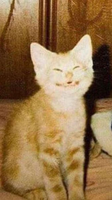

In [ ]:
#| eval: false
# %%fr +1 reply
import requests
from PIL import Image
from io import BytesIO

# Download an image of a cat
url = "https://cataas.com/cat"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Resize the image to 200 on the long side
aspect_ratio = img.width / img.height
if img.width > img.height:
    new_size = (200, int(200 / aspect_ratio))
else:
    new_size = (int(200 * aspect_ratio), 200)

resized_img = img.resize(new_size, Image.LANCZOS)

# Display the resized image
resized_img